# q1

In [1]:
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings('ignore')

# 加载张量
X_train_loaded = torch.load('X_train.pt')
y_train_loaded = torch.load('y_train.pt')
lengths_train_loaded = torch.load('lengths_train.pt')

X_test_loaded = torch.load('X_test.pt')
y_test_loaded = torch.load('y_test.pt')
lengths_test_loaded = torch.load('lengths_test.pt')

train_loader = DataLoader(TensorDataset(X_train_loaded, y_train_loaded, lengths_train_loaded), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_loaded, y_test_loaded, lengths_test_loaded), batch_size=128, shuffle=False)

class GRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x, lengths):
        h0 = torch.zeros(self.gru.num_layers, x.size(0), hidden_size).to(x.device)

        if type(lengths)==int:
          sorted_lengths = torch.tensor([lengths]).to(x.device)
          sorted_x = x
        else:
          # 排序输入和长度，以便最长的序列是第一个
          sorted_lengths, sort_idx = lengths.sort(descending=True)
          sorted_x = x[sort_idx]

        packed_x = nn.utils.rnn.pack_padded_sequence(sorted_x, sorted_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, hn = self.gru(packed_x, h0)  # GRU只返回一个hidden state，没有cell state
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # 获取每个序列的最后一个有效时间步的索引
        last_indices = (output_lengths - 1).long()

        # 直接使用索引获取最后一个时间步的输出
        last_output = output[torch.arange(output.size(0)), last_indices, :]

        if type(lengths)!=int:
          # 由于我们对输入进行了排序，现在需要恢复原始顺序
          _, original_idx = sort_idx.sort()  # 获取排序的逆序
          last_output = last_output[original_idx]
        last_output = self.layer_norm(last_output)
        last_output = self.dropout(last_output)
        # 通过全连接层得到logits
        logits = self.fc(last_output)
        return logits
input_size = 2  # (动作, 时间) 对
hidden_size = 128
num_layers = 1
# 初始化模型、损失函数和优化器
GRUmodel = GRUClassifier(input_size, hidden_size, num_layers)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, lengths):
        h0 = torch.zeros(self.lstm.num_layers, x.size(0), hidden_size).to(x.device)
        c0 = torch.zeros(self.lstm.num_layers, x.size(0), hidden_size).to(x.device)
        if type(lengths)==int:
          sorted_lengths = torch.tensor([lengths]).to(x.device)
          sorted_x = x
        else:
          # 排序输入和长度，以便最长的序列是第一个
          sorted_lengths, sort_idx = lengths.sort(descending=True)
          sorted_x = x[sort_idx]

        # 打包序列
        packed_x = nn.utils.rnn.pack_padded_sequence(sorted_x, sorted_lengths.cpu(), batch_first=True, enforce_sorted=False)
        # 传递到 LSTM
        packed_output, (hn, cn) = self.lstm(packed_x, (h0, c0))
        # 解包序列
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # 获取每个序列的最后一个有效时间步的索引
        last_indices = (output_lengths - 1).long()

        # 直接使用索引获取最后一个时间步的输出
        # 注意：由于 output 是 batch_first=True，所以我们需要从第二个维度（索引为1）进行索引
        last_output = output[torch.arange(output.size(0)), last_indices, :]

        if type(lengths)!=int:
          # 由于我们对输入进行了排序，现在需要恢复原始顺序
          _, original_idx = sort_idx.sort()  # 获取排序的逆序
          last_output = last_output[original_idx]
        
        last_output = self.layer_norm(last_output)
        last_output = self.dropout(last_output)
        # 通过全连接层得到logits
        logits = self.fc(last_output)
        return logits
input_size = 2  # (动作, 时间) 对
hidden_size = 128
num_layers = 1
# 初始化模型、损失函数和优化器
LSTMmodel = LSTMClassifier(input_size, hidden_size, num_layers)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len, dropout=0.1):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Linear(input_dim, model_dim)
        self.position_encoding = nn.Parameter(torch.zeros(1, max_seq_len, model_dim))
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=model_dim,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=0.1,  # 设置Dropout比例
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.layer_norm = nn.LayerNorm(model_dim)  # 添加层归一化
        self.fc = nn.Linear(model_dim, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)  # 使用Xavier均匀初始化权重
                if m.bias is not None:
                    m.bias.data.fill_(0)  # 偏置项初始化为0.1

    def forward(self, x, lengths):
        x = self.embedding(x) + self.position_encoding[:, :x.size(1), :]

        attention_mask = self.create_attention_mask(lengths, x.size(1)).to(x.device)

        x = self.transformer(x, src_key_padding_mask=attention_mask)
        x = self.layer_norm(x)  # 层归一化
#         x, _ = x.max(dim=1)  # Global average pooling over the sequence
        x = self.masked_mean(x, lengths, dim=0)
        x = self.fc(x)
        return x

    def create_attention_mask(self, lengths, max_len):
        if isinstance(lengths, int):
            lengths = torch.tensor([lengths]).to(device)
        attention_mask = torch.zeros(len(lengths), max_len, dtype=torch.bool)
        for i, length in enumerate(lengths):
            attention_mask[i, :length] = 1
        return ~attention_mask

    def masked_mean(self, x, lengths, dim=0):  
        batch_size = x.size(0)  
        result = []  
        for i in range(batch_size): 
            if isinstance(lengths, int):
                length = lengths
            else:
                length = lengths[i]  
            sliced = x[i, :length, :]  
            mean_value = sliced.mean(dim=dim)  
            result.append(mean_value)  
        result_tensor = torch.stack(result)  
        return result_tensor 
input_dim = 2
model_dim = 128  # Dimension of the embeddings and transformer model
dim_feedforward = 256
num_heads = 8  # Number of attention heads
num_layers = 2  # Number of transformer encoder layers
num_classes = 1  # Number of classes for classification
max_seq_len = X_train_loaded.size(1)  # Maximum sequence length
# Instantiate the model
TFmodel = TransformerClassifier(input_dim, model_dim, num_heads, num_layers, dim_feedforward, num_classes, max_seq_len, dropout=0.1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRUmodel.load_state_dict(torch.load('GRUmodel_q1_final.pth', map_location=device)) 
LSTMmodel.load_state_dict(torch.load('LSTMmodel_q1_final.pth', map_location=device))
TFmodel.load_state_dict(torch.load('TFmodel_q1_final.pth', map_location=device))

<All keys matched successfully>

In [2]:
from sklearn.metrics import roc_auc_score

models = [GRUmodel, LSTMmodel, TFmodel]
for model in models:
    model.eval()
    correct = 0
    total = 0
    all_probs = []
    with torch.no_grad():
        for inputs, labels, lengths in test_loader:
            inputs, labels, lengths = inputs.to(device), labels.to(device), lengths.to(device)

            outputs = model(inputs, lengths).squeeze()
            probabilities = torch.sigmoid(outputs)  # 将 logits 转换为概率
            predicted = (probabilities >= 0.5).long()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_probs.extend(probabilities.numpy())
    auc = roc_auc_score(y_test_loaded, all_probs)
    print(f'AUC of the {model} on the test data: {auc:.4f}')
    # print(f'Accuracy of the {model} on the test data: {100 * correct / total:.2f}%')

AUC of the GRUClassifier(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
) on the test data: 0.8723
AUC of the LSTMClassifier(
  (lstm): LSTM(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
) on the test data: 0.8732
AUC of the TransformerClassifier(
  (embedding): Linear(in_features=2, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace

In [2]:
import torch
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

train_shape = (X_train_loaded.size(0) * X_train_loaded.size(1), X_train_loaded.size(2))  
test_shape = (X_test_loaded.size(0) * X_test_loaded.size(1), X_test_loaded.size(2)) 

reshaped_X_train_loaded = X_train_loaded.contiguous().view(*train_shape) 
reshaped_X_test_loaded = X_test_loaded.contiguous().view(*test_shape) 

train_array = reshaped_X_train_loaded.numpy()
test_array = reshaped_X_test_loaded.numpy() 
   
train_df = pd.DataFrame(train_array, columns=['action', 'time'])  
train_ids = np.repeat(np.arange(X_train_loaded.size(0)), X_train_loaded.size(1))  
train_df['ID'] = train_ids 

test_df = pd.DataFrame(test_array, columns=['action', 'time'])  
test_ids = np.repeat(np.arange(X_train_loaded.size(0), X_train_loaded.size(0)+X_test_loaded.size(0)), X_test_loaded.size(1))  
test_df['ID'] = test_ids 
  
train_df = train_df[train_df['action'] != -1]
test_df = test_df[test_df['action'] != -1]

train_label = y_train_loaded.numpy()
test_label = y_test_loaded.numpy()

from itertools import chain  
from collections import defaultdict  

df = pd.concat([train_df, test_df]) 
grouped = df.groupby('ID')  
last_times = grouped['time'].max() 
action_count = grouped['action'].count()
  
# 创建一个函数来生成N-grams并计数  
def generate_ngrams(series, n):  
    return [' '.join(map(str, series[i:i+n])) for i in range(len(series)-n+1)]  
  
# 创建一个空字典来存储N-gram特征和计数  
ngrams_features = defaultdict(lambda: defaultdict(int))  
  
# 对每个ID生成N-grams并计数  
for id_, group in grouped:  
    actions = group['action'].tolist()  
    for n in range(1, 3):  # 生成1-gram, 2-gram
        for ngram in generate_ngrams(actions, n):  
            ngrams_features[id_][ngram] += 1  
            
# 将N-gram特征转换为DataFrame  
feature_names = set(chain.from_iterable(ngrams_features.values()))  
ngram_df = pd.DataFrame(0, index=df['ID'].unique(), columns=list(feature_names))  
  
for id_, counts in ngrams_features.items():  
    for ngram, count in counts.items():  
        ngram_df.at[id_, ngram] = count  

ngram_df['last_time'] = last_times  
ngram_df['action_count'] = action_count 
train_features = ngram_df.iloc[:13410]
test_features = ngram_df.iloc[13410:]

from sklearn.linear_model import LogisticRegression    
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')
  
# 创建逻辑回归模型实例  
Logitmodel_q1_ngram = LogisticRegression()  # 增加max_iter以防收敛问题  

# 训练模型  
Logitmodel_q1_ngram.fit(train_features, train_label)  
  
# （可选）评估模型 
score = Logitmodel_q1_ngram.score(test_features, test_label) 

# 预测测试集的概率  
test_probs = Logitmodel_q1_ngram.predict_proba(test_features)[:, 1]  # 获取正类的概率  
  
# 计算AUC  
auc_score = roc_auc_score(test_label, test_probs)  
  
# 输出AUC  
print(f"AUC: {auc_score:.4f}")
print(f"Train accuracy: {Logitmodel_q1_ngram.score(train_features, train_label):.4f}")  
print(f"Test accuracy: {score:.4f}")  

AUC: 0.8722
Train accuracy: 0.8243
Test accuracy: 0.8279


In [3]:
action_count = []
ngrams_features = defaultdict(lambda: defaultdict(int)) 

for id_ in range(13410, 16763):  
    id_data = df.loc[df['ID'] == id_]  
    n_rows = len(id_data) 
    for prefix_len in range(1, n_rows + 1):  
        prefix_data = id_data.iloc[:prefix_len]     
        
        action_count.append((id_, prefix_len, len(prefix_data))) 
        
        for n in range(1, 3):  # 生成1-gram, 2-gram
            for ngram in generate_ngrams(prefix_data['action'], n):  
                ngrams_features[(id_, prefix_len)][ngram] += 1  

action_count_features = pd.DataFrame(  
    {  'action_count': [f[2] for f in action_count] },  
    index=pd.MultiIndex.from_tuples([f[:2] for f in action_count])  # 使用第一个特征的索引作为 DataFrame 的索引  
)  

ngram_df = pd.DataFrame(0, index=action_count_features.index, columns=list(feature_names))  
  
for (id_, prefix_len), counts in ngrams_features.items():  
    for ngram, count in counts.items():  
        ngram_df.at[(id_, prefix_len), ngram] = count  
ngram_df['last_time'] = test_df['time'].values
ngram_df['action_count'] = action_count_features['action_count'].values
# 初始化字典来存储每个 ID 的概率曲线和标签
long_prob_curve_logit = {}
long_labels_logit = {}

# 遍历测试集
for id_ in range(13410, 16763):
    expanded_id_features = ngram_df.loc[id_,:]
    if len(expanded_id_features)>10:
        long_prob_curve_logit[id_ - 13410] = Logitmodel_q1_ngram.predict_proba(expanded_id_features)[:, 1]  # 将概率曲线存储为 numpy 数组
        long_labels_logit[id_ - 13410] = test_label[id_ - 13410]  # 存储实际的 test_label

Number of samples where all models are correct: 2366
Number of samples where all models are incorrect: 320
Number of all samples: 3353


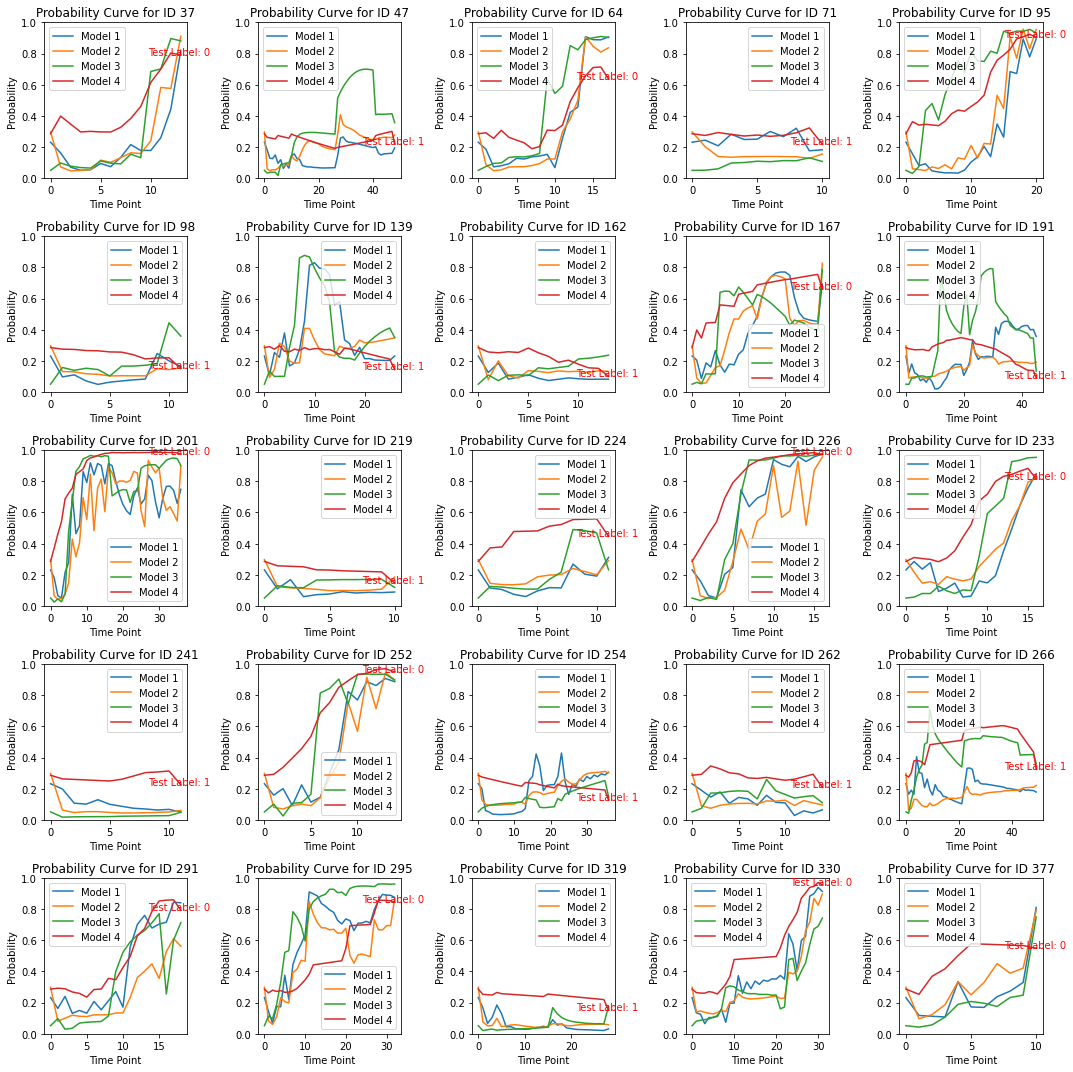

In [5]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _, lengths in data_loader:
            inputs, lengths = inputs.to(device), lengths.to(device)
            outputs = model(inputs, lengths)
            probabilities = torch.sigmoid(outputs.squeeze())
            predicted = (probabilities >= 0.5).long()
            predictions.append(predicted.cpu())
    return torch.cat(predictions)

# 获取三个模型的预测结果
gru_predictions = get_predictions(GRUmodel, test_loader, device)
lstm_predictions = get_predictions(LSTMmodel, test_loader, device)
tf_predictions = get_predictions(TFmodel, test_loader, device)
# fnet_predictions = get_predictions(FNetmodel, test_loader, device)
logit_predictions = torch.tensor(Logitmodel_q1_ngram.predict(test_features))

# 获取标签
labels = y_test_loaded

# 获取三个模型都分类正确的索引
all_correct_indices = (gru_predictions == labels) & (lstm_predictions == labels) & (tf_predictions == labels) & (logit_predictions == labels)#& (fnet_predictions == labels)
all_correct_samples = torch.nonzero(all_correct_indices).squeeze().tolist()

# 获取三个模型都分类错误的索引
all_incorrect_indices = (gru_predictions != labels) & (lstm_predictions != labels) & (tf_predictions != labels) & (logit_predictions != labels) #& (fnet_predictions != labels)
all_incorrect_samples = torch.nonzero(all_incorrect_indices).squeeze().tolist()

# 打印分类正确和分类错误的样本数
print(f"Number of samples where all models are correct: {len(all_correct_samples)}")
print(f"Number of samples where all models are incorrect: {len(all_incorrect_samples)}")
print(f"Number of all samples: {len(gru_predictions)}")

# 初始化字典来存储每个模型的概率曲线和标签
long_prob_curve_TF1 = {}
long_prob_curve_TF2 = {}
long_prob_curve_TF3 = {}
long_prob_curve_TF4 = {}
long_labels_TF = {}

# 假设三个模型分别是 TFmodel1, TFmodel2, TFmodel3
models = [GRUmodel, LSTMmodel, TFmodel]#, FNetmodel
long_prob_curve_dicts = [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4]#, long_prob_curve_TF4

for i, (test_seq, test_label, test_len) in enumerate(zip(X_test_loaded, y_test_loaded, lengths_test_loaded)):
    if i not in all_incorrect_samples:
        continue  # 只处理分类错误的样本

    if test_len > 10:
        for model, prob_curve_dict in zip(models, long_prob_curve_dicts[:3]):
            prob_curve = []
            for t in range(1, test_len + 1):
                current_seq = test_seq[:t].unsqueeze(0)  # 添加批次维度
                current_seq = current_seq.to(device)
                with torch.no_grad():
                    logits = model(current_seq, t)
                    probs = torch.sigmoid(logits)
                prob_curve.append(probs.squeeze().cpu().numpy())
            prob_curve_dict[i] = np.array(prob_curve)  # 使用索引 i 作为 ID
        long_prob_curve_TF4[i] = long_prob_curve_logit[i]
        long_labels_TF[i] = test_label.numpy()

# 绘制分类错误的样本的概率曲线图
import matplotlib.pyplot as plt

valid_ids = list(long_labels_TF.keys())[:25]  # 选择最多25个样本

fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    
    for model_idx, prob_curve_dict in enumerate(long_prob_curve_dicts):
        prob_curve = prob_curve_dict[id_]
        ax.plot(prob_curve, label=f'Model {model_idx + 1}')

    labels = long_labels_TF[id_]
    # 设置y轴范围  
    ax.set_ylim(0, 1) 
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Probability')
    ax.set_title(f'Probability Curve for ID {id_}')
    
    time_point = len(prob_curve) - 1
    probability = prob_curve[-1]
    ax.annotate(f'Test Label: {labels}',
                xy=(time_point, probability),
                xytext=(time_point * 0.75, probability),
                fontsize=10,
                color='red')

# 添加图例
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

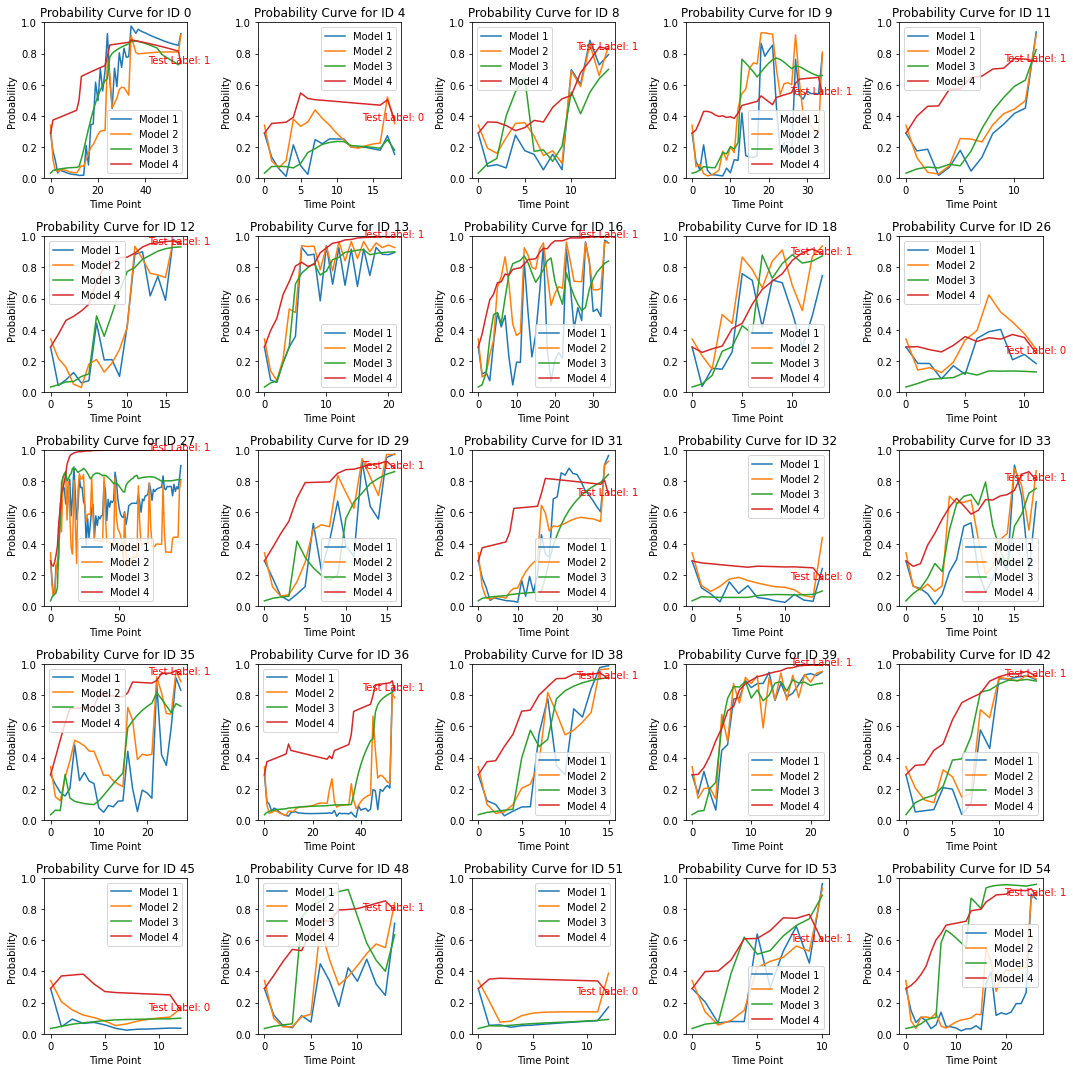

In [7]:
long_prob_curve_TF1 = {}
long_prob_curve_TF2 = {}
long_prob_curve_TF3 = {}
long_prob_curve_TF4 = {}
long_labels_TF = {}

# 假设三个模型分别是 TFmodel1, TFmodel2, TFmodel3
models = [GRUmodel, LSTMmodel, TFmodel]#, FNetmodel
long_prob_curve_dicts = [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4]

for i, (test_seq, test_label, test_len) in enumerate(zip(X_test_loaded, y_test_loaded, lengths_test_loaded)):
    if i not in all_correct_samples:
        continue  # 只处理分类错误的样本

    if test_len > 10:
        for model, prob_curve_dict in zip(models, long_prob_curve_dicts[:3]):
            prob_curve = []
            for t in range(1, test_len + 1):
                current_seq = test_seq[:t].unsqueeze(0)  # 添加批次维度
                current_seq = current_seq.to(device)
                with torch.no_grad():
                    logits = model(current_seq, t)
                    probs = torch.sigmoid(logits)
                prob_curve.append(probs.squeeze().cpu().numpy())
            prob_curve_dict[i] = np.array(prob_curve)  # 使用索引 i 作为 ID
        long_prob_curve_TF4[i] = long_prob_curve_logit[i]
        long_labels_TF[i] = test_label.numpy()

# 绘制分类错误的样本的概率曲线图
import matplotlib.pyplot as plt

valid_ids = list(long_labels_TF.keys())[:25]  # 选择最多25个样本

fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    
    for model_idx, prob_curve_dict in enumerate(long_prob_curve_dicts):
        prob_curve = prob_curve_dict[id_]
        ax.plot(prob_curve, label=f'Model {model_idx + 1}')

    labels = long_labels_TF[id_]
    # 设置y轴范围  
    ax.set_ylim(0, 1) 
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Probability')
    ax.set_title(f'Probability Curve for ID {id_}')
    
    time_point = len(prob_curve) - 1
    probability = prob_curve[-1]
    ax.annotate(f'Test Label: {labels}',
                xy=(time_point, probability),
                xytext=(time_point * 0.75, probability),
                fontsize=10,
                color='red')

# 添加图例
for ax in axs.flat:
    ax.legend()

plt.tight_layout()
plt.show()

In [4]:
# 初始化字典来存储每个模型的概率曲线和标签
long_prob_curve_TF1 = {}
long_prob_curve_TF2 = {}
long_prob_curve_TF3 = {}
long_prob_curve_TF4 = {}
long_labels_TF = {}

# 假设三个模型分别是 TFmodel1, TFmodel2, TFmodel3
models = [GRUmodel, LSTMmodel, TFmodel]#, FNetmodel
long_prob_curve_dicts = [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4]#, long_prob_curve_TF4

for i, (test_seq, test_label, test_len) in enumerate(zip(X_test_loaded, y_test_loaded, lengths_test_loaded)):
    if test_len > 10:
        for model, prob_curve_dict in zip(models, long_prob_curve_dicts[:3]):
            prob_curve = []
            for t in range(1, test_len + 1):
                current_seq = test_seq[:t].unsqueeze(0)  # 添加批次维度
                current_seq = current_seq.to(device)
                with torch.no_grad():
                    logits = model(current_seq, t)
                    probs = torch.sigmoid(logits)
                prob_curve.append(probs.squeeze().cpu().numpy())
            prob_curve_dict[i] = np.array(prob_curve)  # 使用索引 i 作为 ID
        long_prob_curve_TF4[i] = long_prob_curve_logit[i]
        long_labels_TF[i] = test_label.numpy()

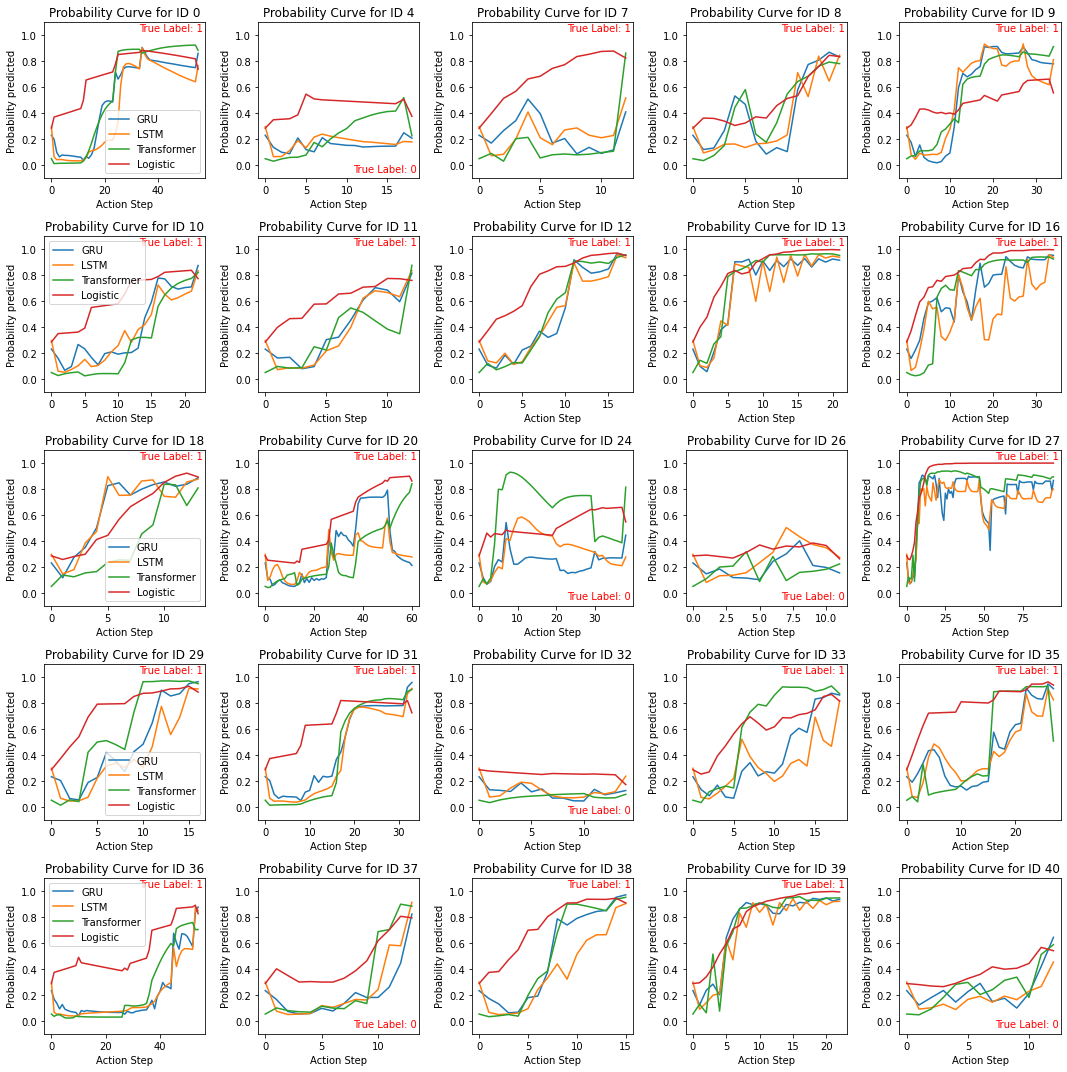

In [7]:
# 绘制分类错误的样本的概率曲线图
import matplotlib.pyplot as plt

valid_ids = list(long_labels_TF.keys())[:25]  # 选择最多25个样本
model_names = ['GRU', 'LSTM', 'Transformer', 'Logistic']

fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    
    for model_idx, prob_curve_dict in enumerate(long_prob_curve_dicts):
        prob_curve = prob_curve_dict[id_]
        ax.plot(prob_curve, label=model_names[model_idx])

    labels = long_labels_TF[id_]
    # 设置y轴范围  
    ax.set_ylim(-0.1, 1.1) 
    ax.set_xlabel('Action Step')
    ax.set_ylabel('Probability predicted')
    ax.set_title(f'Probability Curve for ID {id_}')
    
    time_point = len(prob_curve) - 1
    probability = prob_curve[-1]
    if labels == 1:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, 1.05),
                    xytext=(time_point * 0.6, 1.03),
                    fontsize=10,
                    color='red')
    if labels == 0:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, -0.05),
                    xytext=(time_point * 0.6, -0.05),
                    fontsize=10,
                    color='red')
    if col == 0:  # 只在第一列显示图例  
        ax.legend()  
    
plt.tight_layout()
plt.show()

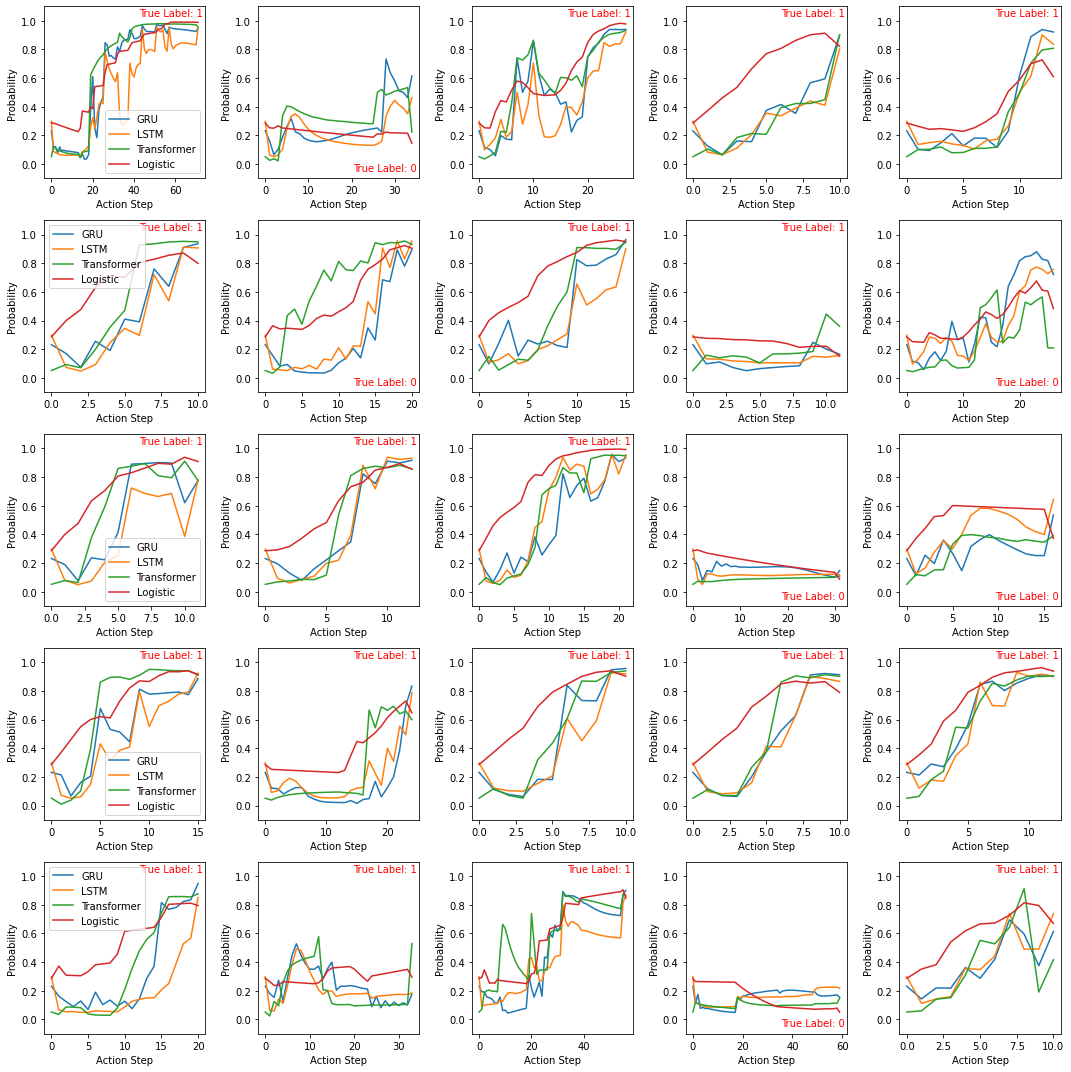

In [8]:
# 绘制分类错误的样本的概率曲线图
import matplotlib.pyplot as plt

valid_ids = list(long_labels_TF.keys())[50:75]  # 选择最多25个样本
model_names = ['GRU', 'LSTM', 'Transformer', 'Logistic']

fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    
    for model_idx, prob_curve_dict in enumerate(long_prob_curve_dicts):
        prob_curve = prob_curve_dict[id_]
        ax.plot(prob_curve, label=model_names[model_idx])

    labels = long_labels_TF[id_]
    # 设置y轴范围  
    ax.set_ylim(-0.1, 1.1) 
    ax.set_xlabel('Action Step')
    ax.set_ylabel('Probability')
    # ax.set_title(f'Probability Curve for ID {id_}')
    
    time_point = len(prob_curve) - 1
    probability = prob_curve[-1]
    if labels == 1:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, 1.05),
                    xytext=(time_point * 0.6, 1.03),
                    fontsize=10,
                    color='red')
    if labels == 0:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, -0.05),
                    xytext=(time_point * 0.6, -0.05),
                    fontsize=10,
                    color='red')
    if col == 0:  # 只在第一列显示图例  
        ax.legend()  
    
plt.tight_layout()
plt.show()

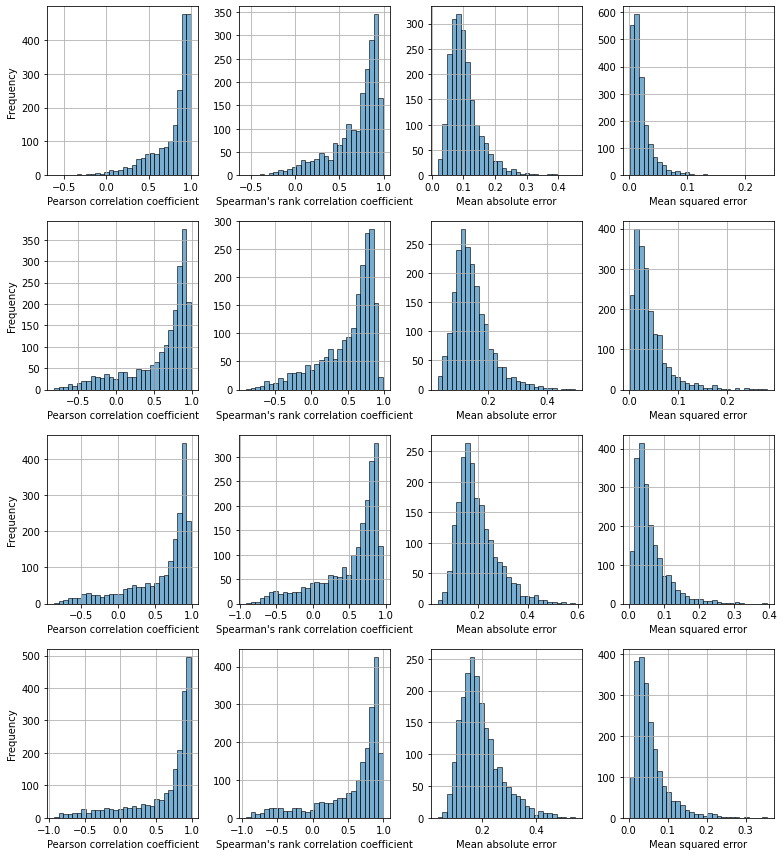

In [32]:
import scipy
pearson12 = {}  
spearman12 = {}  
pearson13 = {}  
spearman13 = {}  
pearson14 = {}  
spearman14 = {}  
pearson34 = {}  
spearman34 = {}  
MAE12 = {}  
MSE12 = {}  
MAE13 = {}  
MSE13 = {}  
MAE14 = {}  
MSE14 = {}  
MAE34 = {}  
MSE34 = {}
for id_ in long_prob_curve_TF1:  
    if id_ in long_prob_curve_TF2:  
        gru_curve = long_prob_curve_TF1[id_]  
        lstm_curve = long_prob_curve_TF2[id_]  
        tf_curve = long_prob_curve_TF3[id_] 
        logit_curve = long_prob_curve_TF4[id_]
        pearson12[id_] = scipy.stats.pearsonr(gru_curve, lstm_curve)[0]
        spearman12[id_] = scipy.stats.spearmanr(gru_curve, lstm_curve)[0]
        pearson13[id_] = scipy.stats.pearsonr(gru_curve, tf_curve)[0]
        spearman13[id_] = scipy.stats.spearmanr(gru_curve, tf_curve)[0]
        pearson14[id_] = scipy.stats.pearsonr(gru_curve, logit_curve)[0]
        spearman14[id_] = scipy.stats.spearmanr(gru_curve, logit_curve)[0]
        pearson34[id_] = scipy.stats.pearsonr(tf_curve, logit_curve)[0]
        spearman34[id_] = scipy.stats.spearmanr(tf_curve, logit_curve)[0]
        MAE12[id_] = np.mean(np.abs(gru_curve - lstm_curve))
        MSE12[id_] = np.mean((gru_curve - lstm_curve) ** 2)
        MAE13[id_] = np.mean(np.abs(gru_curve - tf_curve))
        MSE13[id_] = np.mean((gru_curve - tf_curve) ** 2)
        MAE14[id_] = np.mean(np.abs(gru_curve - logit_curve))
        MSE14[id_] = np.mean((gru_curve - logit_curve) ** 2)
        MAE34[id_] = np.mean(np.abs(tf_curve - logit_curve))
        MSE34[id_] = np.mean((tf_curve - logit_curve) ** 2)
df_similarities = pd.DataFrame.from_dict(pearson12, orient='index', columns=['pearson12'])  
df_similarities['spearman12'] = spearman12.values()
df_similarities['MAE12'] = MAE12.values()
df_similarities['MSE12'] = MSE12.values()
df_similarities['pearson13'] = pearson13.values()
df_similarities['spearman13'] = spearman13.values()
df_similarities['MAE13'] = MAE13.values()
df_similarities['MSE13'] = MSE13.values()
df_similarities['pearson14'] = pearson14.values()
df_similarities['spearman14'] = spearman14.values()
df_similarities['MAE14'] = MAE14.values()
df_similarities['MSE14'] = MSE14.values()
df_similarities['pearson34'] = pearson34.values()
df_similarities['spearman34'] = spearman34.values()
df_similarities['MAE34'] = MAE34.values()
df_similarities['MSE34'] = MSE34.values()

import matplotlib.pyplot as plt  
nrows, ncols = 4, 4  
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(11, 12))  
# 设置每行的标题
titles = [
    'Similarity between GRU and LSTM',
    'Similarity between GRU and Transformer',
    'Similarity between GRU and Logistic Regression',
    'Similarity between Transformer and Logistic Regression'
]  
xlabels = [
    'Pearson correlation coefficient',    # 第一列
    "Spearman's rank correlation coefficient",  # 第二列
    'Mean absolute error',                # 第三列
    'Mean squared error'                  # 第四列
]
# 遍历df_similarities的列和axes数组  
for i, col in enumerate(df_similarities.columns):  
    row = i // ncols  
    col_index = i % ncols  
    ax = axes[row, col_index]
    df_similarities[col].hist(bins=30, alpha=0.6, edgecolor='black', ax=ax)  
    # ax.set_title(col)  
    ax.set_xlabel(xlabels[col_index])  
    # 只有每行的第一个子图显示y轴标签
    if col_index == 0:
        ax.set_ylabel('Frequency')
    # 设置每行的标题
    # if row == 0:
    #     fig.text(0.5, 0.995, titles[row], ha='center', fontsize=12)
    # if row == 1:
    #     fig.text(0.5, 0.745, titles[row], ha='center', fontsize=12)
    # if row == 2:
    #     fig.text(0.5, 0.495, titles[row], ha='center', fontsize=12)
    # if row == 3:
    #     fig.text(0.5, 0.248, titles[row], ha='center', fontsize=12)

# 调整子图间距
plt.subplots_adjust(wspace=0.3, hspace=0.2) # wspace控制水平间距，hspace控制垂直间距
plt.tight_layout()  # 自动调整子图参数, 使之填充整个图像区域  
plt.show()

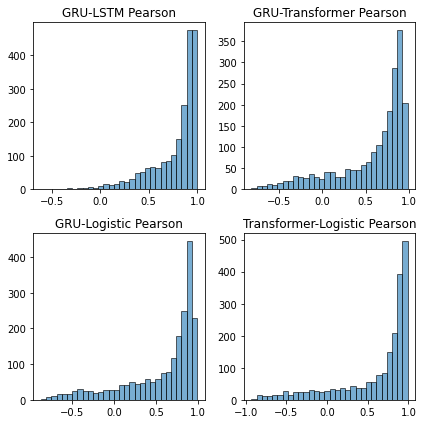

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(6, 6))  # 可以调整figsize来改变子图的大小

# 将数据绘制到对应的子图上
axs[0, 0].hist(df_similarities['pearson12'], bins=30, alpha=0.6, edgecolor='black')
axs[0, 0].set_title('GRU-LSTM Pearson')
# axs[0, 0].set_ylabel('Frequency')

axs[0, 1].hist(df_similarities['pearson13'], bins=30, alpha=0.6, edgecolor='black')
axs[0, 1].set_title('GRU-Transformer Pearson')
# axs[0, 1].set_ylabel('Frequency')

axs[1, 0].hist(df_similarities['pearson14'], bins=30, alpha=0.6, edgecolor='black')
axs[1, 0].set_title('GRU-Logistic Pearson')
# axs[1, 0].set_ylabel('Frequency')

axs[1, 1].hist(df_similarities['pearson34'], bins=30, alpha=0.6, edgecolor='black')
axs[1, 1].set_title('Transformer-Logistic Pearson')
# axs[1, 1].set_ylabel('Frequency')

# 调整子图之间的间距
plt.tight_layout()

# 显示图表
plt.show()

# B-spline fitting

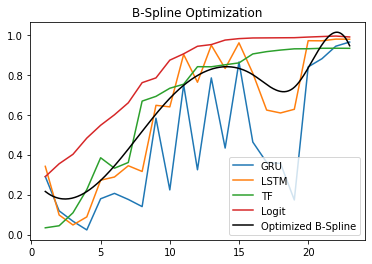

In [20]:
from scipy.optimize import minimize
from scipy.interpolate import BSpline

i = 2157  # 示例样本索引
x = np.arange(1, len(long_prob_curve_TF1[i]) + 1)  # 序列长度从 1 到曲线长度
y1 = long_prob_curve_TF1[i]
y2 = long_prob_curve_TF2[i]
y3 = long_prob_curve_TF3[i]
y4 = long_prob_curve_TF4[i]
y = (y1 + y2 + y3 + y4) / 4

# 定义节点（knot）位置
# knots = np.linspace(1, len(x), num=len(x)//3 + 3)
knots = np.concatenate(([1], x[::3], [len(x), len(x), len(x)]))

# 初始控制点
initial_control_points = np.random.rand(len(knots) - 3)  # 取节点数-3，保证样条是三次

# 定义样条的阶数（degree）
degree = 3

# 定义损失函数
def loss_function(control_points):
    # 构建 B 样条
    spl = BSpline(knots, control_points, degree)    
    # 定义损失函数
    loss = np.sum((spl(x) - y1)**2) + np.sum((spl(x) - y2)**2) + np.sum((spl(x) - y3)**2) + np.sum((spl(x) - y4)**2)
    return loss

# 优化控制点
result = minimize(loss_function, initial_control_points, method='BFGS')

# 构建优化后的 B 样条
spl_optimized = BSpline(knots, result.x, degree)

# 绘制原始数据点
plt.plot(x, y1, label='GRU')
plt.plot(x, y2, label='LSTM')
plt.plot(x, y3, label='TF')
plt.plot(x, y4, label='Logit')
# 绘制优化后的样条曲线
x_fine = np.linspace(x[0], x[-1], 300)
plt.plot(x_fine, spl_optimized(x_fine), label='Optimized B-Spline', color='black')
plt.title('B-Spline Optimization')
plt.legend()
plt.show()

In [5]:
from scipy.optimize import minimize
from scipy.interpolate import BSpline

all_spline = {}
spline_curve = {}

# 定义样条的阶数（degree）
degree = 3
# 定义损失函数
def loss_function(control_points):
    # 构建 B 样条
    spl = BSpline(knots, control_points, degree)    
    # 定义损失函数
    loss = np.sum((spl(x) - y1)**2) + np.sum((spl(x) - y2)**2) + np.sum((spl(x) - y3)**2) + np.sum((spl(x) - y4)**2)
    return loss

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    x_fine = np.linspace(1, len(x), 200)
    y1 = long_prob_curve_TF1[id_]
    y2 = long_prob_curve_TF2[id_]
    y3 = long_prob_curve_TF3[id_]
    y4 = long_prob_curve_TF4[id_]
    y = (y1 + y2 + y3 + y4) / 4

    # 定义节点（knot）位置
    knots = np.concatenate(([1], x[::3], [len(x), len(x), len(x)]))
    # 初始控制点
    initial_control_points = np.random.rand(len(knots) - 3)  # 取节点数-3，保证样条是三次
    # 优化控制点
    result = minimize(loss_function, initial_control_points, method='BFGS')
    # 构建优化后的 B 样条
    spline = BSpline(knots, result.x, degree)

    spline_curve[id_] = spline(x)
    all_spline[id_] = spline(x_fine)
    
# valid_ids = list(long_labels_TF.keys())[75:100]  # 选择最多25个样本
# fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
# for i, id_ in enumerate(valid_ids):
#     row, col = divmod(i, 5)
#     ax = axs[row, col]
#     x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
#     ax.plot(x, long_prob_curve_TF1[id_], label='GRU')
#     ax.plot(x, long_prob_curve_TF2[id_], label='LSTM')
#     ax.plot(x, long_prob_curve_TF3[id_], label='TF')
#     ax.plot(x, long_prob_curve_TF4[id_], label='Logit')

#     # 绘制拟合后的曲线
#     x_fine = np.linspace(1, len(x), 200)
#     ax.plot(x_fine, all_spline[id_], label='Fitted', color='black')
#     labels = long_labels_TF[id_]
#     # 设置y轴范围  
#     ax.set_ylim(-0.1, 1.1) 
#     ax.set_xlabel('Action Step')
#     ax.set_ylabel('Probability')
#     # ax.set_title(f'Probability Curve for ID {id_}')
    
#     time_point = len(prob_curve) - 1
#     if labels == 1:
#         ax.annotate(f'True Label: {labels}',
#                     xy=(time_point, 1.05),
#                     xytext=(time_point, 1.03),
#                     fontsize=10,
#                     color='red')
#     if labels == 0:
#         ax.annotate(f'True Label: {labels}',
#                     xy=(time_point, -0.05),
#                     xytext=(time_point, -0.05),
#                     fontsize=10,
#                     color='red')
#     if col == 0:  # 只在第一列显示图例  
#         ax.legend()   
# plt.tight_layout()
# plt.show()

In [6]:
# 初始化一个变量来存储所有第一个数的总和
first_values_sum = 0
# 初始化一个变量来存储第一个数的数量
count = 0

# 遍历字典中的所有曲线
for curve in spline_curve.values():
    # 检查曲线是否至少有一个元素
    if curve.size > 0:
        # 提取第一个元素并累加
        first_values_sum += curve[0]
        # 增加计数
        count += 1

# 计算平均值
if count > 0:
    average_first_value = first_values_sum / count
else:
    average_first_value = 0

print("所有曲线的第一个数的平均值是:", average_first_value)

所有曲线的第一个数的平均值是: 0.21296412043141316


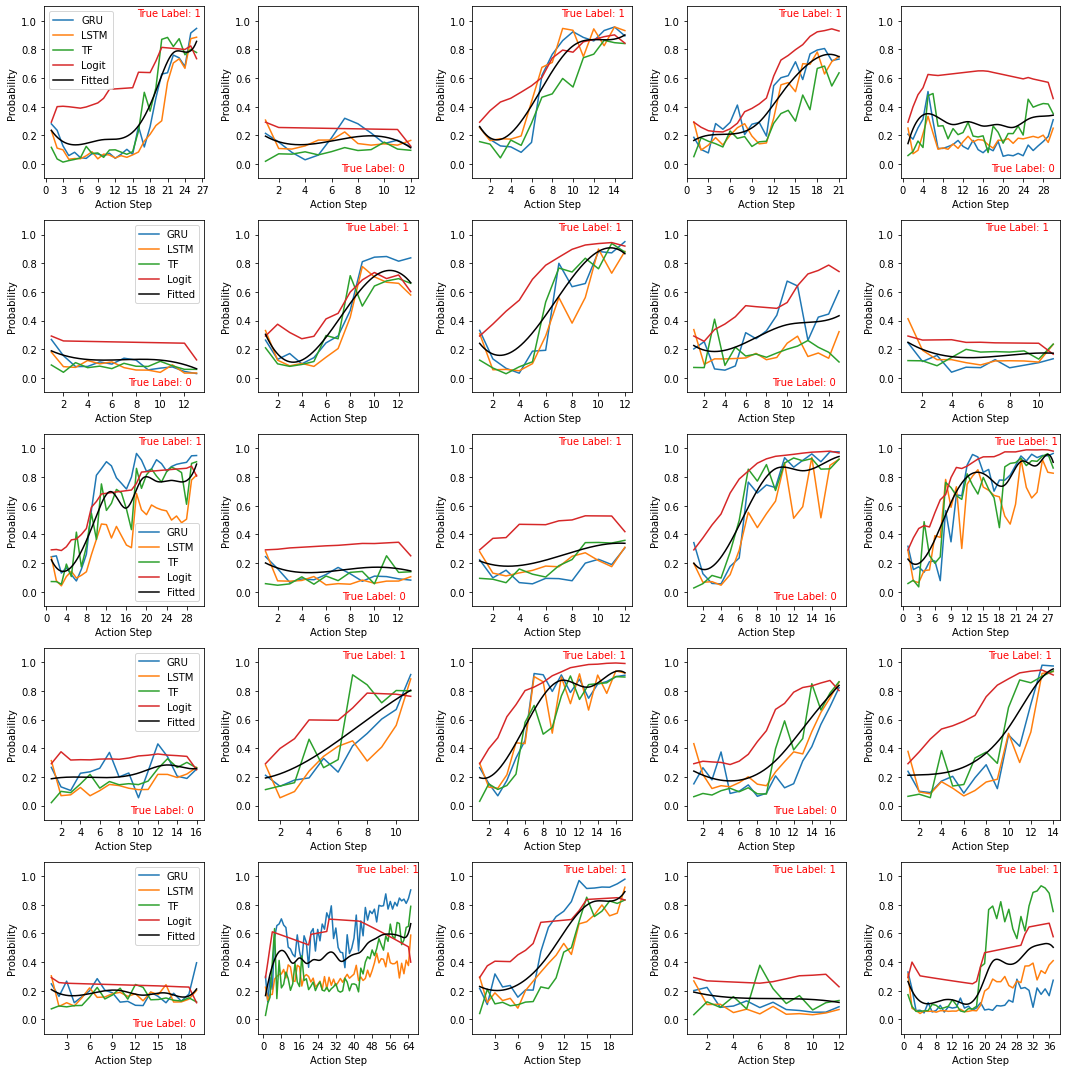

In [6]:
import matplotlib.pyplot as plt  
from matplotlib.ticker import MaxNLocator

valid_ids = list(long_labels_TF.keys())[125:150]  # 选择最多25个样本
fig, axs = plt.subplots(5, 5, figsize=(15, 15))  # 5x5布局
for i, id_ in enumerate(valid_ids):
    row, col = divmod(i, 5)
    ax = axs[row, col]
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    ax.plot(x, long_prob_curve_TF1[id_], label='GRU')
    ax.plot(x, long_prob_curve_TF2[id_], label='LSTM')
    ax.plot(x, long_prob_curve_TF3[id_], label='TF')
    ax.plot(x, long_prob_curve_TF4[id_], label='Logit')

    # 绘制拟合后的曲线
    x_fine = np.linspace(1, len(x), 200)
    ax.plot(x_fine, all_spline[id_], label='Fitted', color='black')
    labels = long_labels_TF[id_]
    # 设置y轴范围  
    ax.set_ylim(-0.1, 1.1) 
    ax.set_xlabel('Action Step')
    ax.set_ylabel('Probability')
    # ax.set_title(f'Probability Curve for ID {id_}')

    # 设置x轴为整数
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    time_point = len(long_prob_curve_TF4[id_]) - 1
    if labels == 1:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, 1.05),
                    xytext=(time_point * 0.63, 1.03),
                    fontsize=10,
                    color='red')
    if labels == 0:
        ax.annotate(f'True Label: {labels}',
                    xy=(time_point, -0.05),
                    xytext=(time_point * 0.61, -0.05),
                    fontsize=10,
                    color='red')
    if col == 0:  # 只在第一列显示图例  
        ax.legend()  

plt.tight_layout()
plt.show()

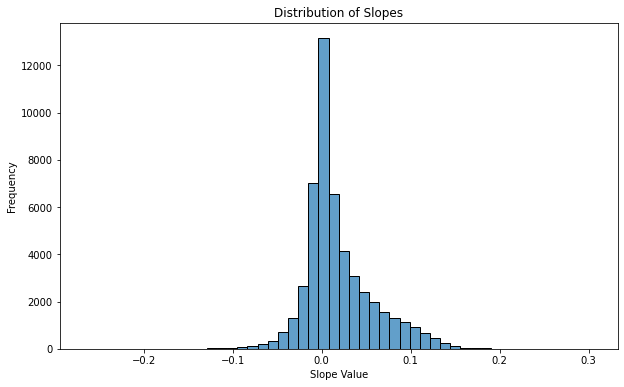

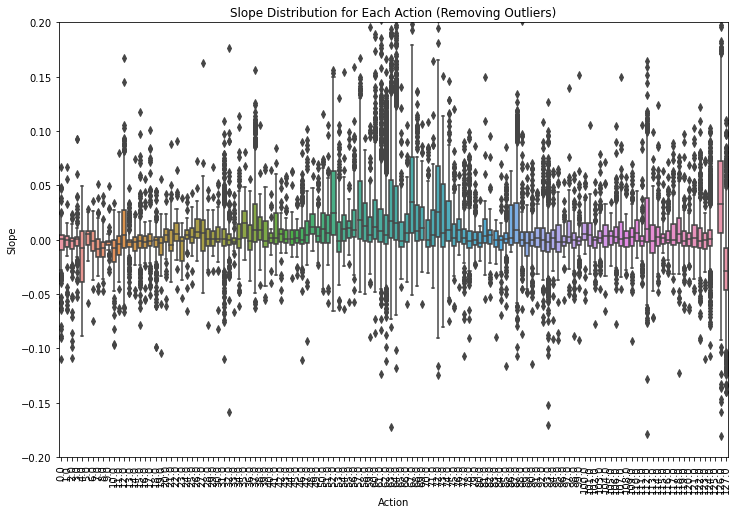

In [66]:
import seaborn as sns
action_diffs = [] # 存储所有斜率值
test_df['id'] = test_df['ID'] - 13410
test_slope1 = test_df[test_df['id'].isin(list(long_labels_TF.keys()))]

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    fitted_curve = spline_curve[id_]
    
    # 计算相邻动作对的平均差分
    diffs = fitted_curve[1:] - fitted_curve[:-1]
    action_diffs.extend(diffs)
    diffs_with_nan = np.insert(diffs, x[-1]-1, np.nan)
    test_slope1.loc[test_slope1['id'] == id_, 'action_diffs'] = diffs_with_nan

# 绘制斜率的直方图
plt.figure(figsize=(10, 6))
sns.histplot(action_diffs, bins=50, alpha=0.7)
plt.title('Distribution of Slopes')
plt.xlabel('Slope Value')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(12, 8))
sns.boxplot(x='action', y='action_diffs', data=test_slope1)
plt.xticks(rotation=90)
plt.ylim(-0.2, 0.2) 
plt.title('Slope Distribution for Each Action (Removing Outliers)')
plt.xlabel('Action')
plt.ylabel('Slope')
plt.show()

In [70]:
import json   
with open('reverse_mapping.json', 'r', encoding='utf-8') as f:  
    reverse_mapping_loaded = json.load(f) 
reverse_mapping = {int(key): value for key, value in reverse_mapping_loaded.items()} 

grouped1 = test_slope1.groupby('action')['action_diffs'].median().reset_index()
grouped2 = test_slope1.groupby('action')['action_diffs'].mean().reset_index(drop=True)
grouped3 = test_slope1.groupby('action')['action_diffs'].count().reset_index(drop=True)
grouped = pd.concat([grouped1, grouped2, grouped3],axis=1)
grouped.columns = ['action', 'median', 'mean', 'count']

large_slope = grouped[grouped['median'] > 0.014]
large_slope['re_action'] = [reverse_mapping[code] for code in large_slope['action']]
print(large_slope)
# large_test_slope1 = test_slope1[test_slope1['action'].isin(large_slope['action'])]
# large_test_slope1['re_action'] = [reverse_mapping[code] for code in large_test_slope1['action']]
# print(large_test_slope1)
negtive_slope = grouped[grouped['median'] < -0.003]
negtive_slope['re_action'] = [reverse_mapping[code] for code in negtive_slope['action']]
print(negtive_slope)
# negtive_test_slope1 = test_slope1[test_slope1['action'].isin(negtive_slope['action'])]
# negtive_test_slope1['re_action'] = [reverse_mapping[code] for code in negtive_test_slope1['action']]
# print(negtive_test_slope1)

     action    median      mean  count re_action
35     35.0  0.014936  0.017726     23   -2_0_-1
52     52.0  0.024381  0.036278    708    0_-1_0
57     57.0  0.018351  0.031534    929    0_-2_0
63     63.0  0.017278  0.031702   2346     0_0_1
64     64.0  0.015849  0.028781   2714     0_0_2
67     67.0  0.034303  0.043590   2581     0_1_0
72     72.0  0.025881  0.037891   2573     0_2_0
126   126.0  0.032811  0.040137   7328     reset
     action    median      mean  count re_action
4       4.0 -0.008019 -0.016641     12   -1_-1_2
7       7.0 -0.008336 -0.005653     39   -1_-2_0
8       8.0 -0.007218 -0.008546     61   -1_-2_1
10     10.0 -0.007697 -0.011498    126   -1_0_-1
11     11.0 -0.003586 -0.006813     44   -1_0_-2
21     21.0 -0.004457  0.002624     55   -1_2_-2
89     89.0 -0.003380 -0.002862     57     1_0_2
127   127.0 -0.028516 -0.027499   2062     start


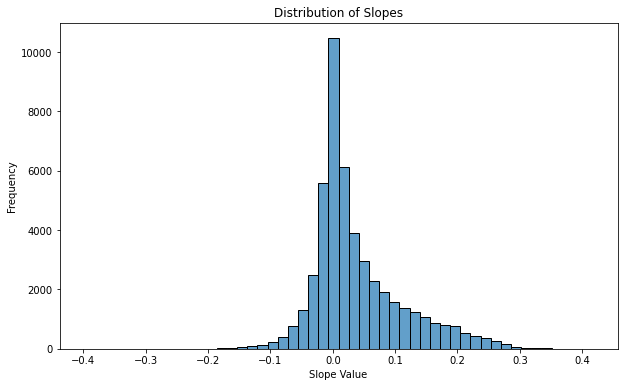

In [77]:
import seaborn as sns
gram_diffs = [] # 存储所有斜率值
test_df['id'] = test_df['ID'] - 13410
test_slope2 = test_df[test_df['id'].isin(list(long_labels_TF.keys()))]
test_slope2['real_action'] = [reverse_mapping[code] for code in test_slope2['action']]
test_slope2['pre_action'] = test_slope2['real_action'].shift(1)
test_slope2['2gram'] = test_slope2.apply(lambda row: (row['pre_action'], row['real_action']), axis=1)

for id_ in list(long_labels_TF.keys()):
    x = np.arange(1, len(long_prob_curve_TF1[id_]) + 1)
    fitted_curve = spline_curve[id_]
    
    # 计算相邻动作对的平均差分
    diffs = fitted_curve[2:] - fitted_curve[:-2]
    gram_diffs.extend(diffs)
    diffs_with_nan = np.insert(diffs, 0, np.nan)
    diffs_with_nan = np.insert(diffs_with_nan, x[-1]-1, np.nan)
    test_slope2.loc[test_slope2['id'] == id_, 'gram_diffs'] = diffs_with_nan

# 绘制斜率的直方图
plt.figure(figsize=(10, 6))
sns.histplot(gram_diffs, bins=50, alpha=0.7)
plt.title('Distribution of Slopes')
plt.xlabel('Slope Value')
plt.ylabel('Frequency')
plt.show()
# plt.figure(figsize=(12, 8))
# sns.boxplot(x='2gram', y='gram_diffs', data=test_slope2)
# plt.xticks(rotation=45)
# plt.ylim(-0.3, 0.3) 
# plt.title('Slope Distribution for Each Action (Removing Outliers)')
# plt.xlabel('Action')
# plt.ylabel('Slope')
# plt.show()

In [87]:
grouped1 = test_slope2.groupby('2gram')['gram_diffs'].median().reset_index()
grouped2 = test_slope2.groupby('2gram')['gram_diffs'].mean().reset_index(drop=True)
grouped3 = test_slope2.groupby('2gram')['gram_diffs'].count().reset_index(drop=True)
grouped = pd.concat([grouped1, grouped2, grouped3],axis=1)
grouped.columns = ['2gram', 'median', 'mean', 'count']

large_slope = grouped[(grouped['median'] > 0.13)&(grouped['count'] > 20)]
print(large_slope)
large_test_slope2 = test_slope2[test_slope2['2gram'].isin(large_slope['2gram'])]
# print(large_test_slope2)
negtive_slope = grouped[(grouped['median'] > -0.02)&(grouped['median'] < -0.01)&(grouped['count'] > 20)]
print(negtive_slope)
negtive_test_slope2 = test_slope2[test_slope2['2gram'].isin(negtive_slope['2gram'])]
# print(negtive_test_slope1)

                2gram    median      mean  count
887   (0_-1_0, reset)  0.134989  0.123930    146
1257   (0_1_0, 0_2_0)  0.137033  0.132959    268
1270   (0_1_0, reset)  0.145696  0.136811    665
1354  (0_2_0, 0_-1_0)  0.136168  0.129893     62
1355  (0_2_0, 0_-2_0)  0.161890  0.143973    115
1361   (0_2_0, 0_1_0)  0.137932  0.131393     31
1375   (0_2_0, reset)  0.130911  0.129124    652
2155   (2_0_0, 0_1_0)  0.143764  0.131827     23
2487   (reset, 0_1_0)  0.149768  0.137142    812
                   2gram    median      mean  count
132   (-1_-2_1, -1_-2_1) -0.014516 -0.019362     40
156   (-1_0_-1, -1_0_-1) -0.016178 -0.025275     78
179   (-1_0_-2, -1_0_-2) -0.010765 -0.018608     21
200     (-1_0_0, -1_1_0) -0.010529 -0.014717     21
371   (-1_2_-2, -1_2_-2) -0.016720 -0.004686     36
1659      (1_0_0, 1_1_0) -0.015444 -0.006011    164
2583      (start, 0_0_1) -0.015337 -0.013805     77


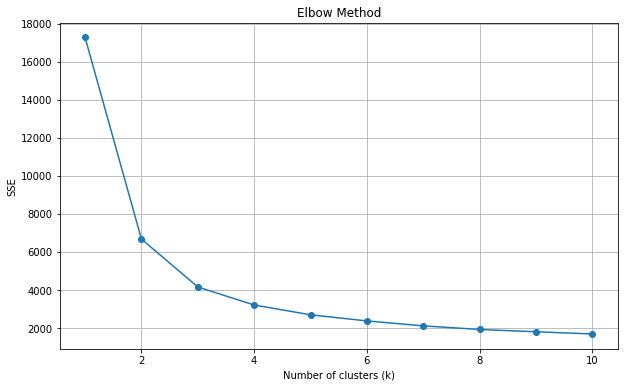

In [9]:
from sklearn.cluster import KMeans

# 将插值后的曲线值转换为数组
cluster_curves = []
for id_ in list(long_labels_TF.keys()):
    cluster_curves.append(all_spline[id_])
curves_array = np.array(cluster_curves)

# 初始化一个列表来保存每个 k 值的 SSE
sse = []

# 尝试不同的 k 值
for k in range(1, 11):  # 例如，测试从 1 到 10 的 k 值
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(curves_array)
    sse.append(kmeans.inertia_)  # inertia_ 属性是模型的 SSE

# 绘制 SSE 随 k 值的变化
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.grid(True)
plt.show()

In [17]:
import matplotlib.pyplot as plt

# 创建KMeans聚类器
kmeans = KMeans(n_clusters=3)
# 拟合模型
kmeans.fit(curves_array)
# 聚类标签
labels = kmeans.labels_

# 统计每个聚类的样本数目
unique_clusters, counts = np.unique(labels, return_counts=True)
# 打印每个聚类的样本数目
print("\nCluster counts:")
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} samples")

cluster_groups = {}  
for idx, cluster_id in zip(long_labels_TF.keys(), labels):  
    if cluster_id not in cluster_groups:  
        cluster_groups[cluster_id] = []  
    cluster_groups[cluster_id].append(idx)  
for cluster_id, indices in cluster_groups.items(): 
    print(cluster_id, indices)


Cluster counts:
Cluster 0: 745 samples
Cluster 1: 700 samples
Cluster 2: 617 samples
2 [0, 9, 12, 13, 16, 18, 27, 29, 31, 38, 39, 58, 60, 61, 72, 82, 86, 101, 104, 108, 113, 119, 130, 138, 149, 156, 159, 168, 171, 173, 174, 181, 201, 203, 210, 216, 221, 226, 227, 232, 239, 243, 246, 249, 252, 257, 277, 280, 281, 289, 292, 293, 295, 299, 301, 302, 306, 316, 318, 326, 332, 345, 346, 356, 362, 364, 366, 372, 378, 381, 383, 391, 402, 418, 420, 425, 429, 430, 439, 440, 446, 448, 449, 458, 466, 468, 473, 475, 481, 483, 492, 500, 507, 508, 512, 519, 523, 526, 527, 528, 554, 563, 569, 572, 576, 579, 581, 583, 585, 587, 591, 597, 599, 600, 602, 606, 607, 619, 626, 629, 630, 631, 634, 635, 637, 653, 660, 663, 665, 671, 672, 676, 679, 688, 693, 696, 700, 706, 707, 710, 712, 723, 731, 745, 749, 750, 751, 754, 756, 763, 787, 791, 792, 796, 800, 803, 827, 832, 838, 839, 848, 849, 853, 864, 869, 872, 878, 880, 882, 886, 889, 891, 894, 903, 904, 911, 923, 929, 944, 946, 947, 968, 969, 973, 977, 988, 

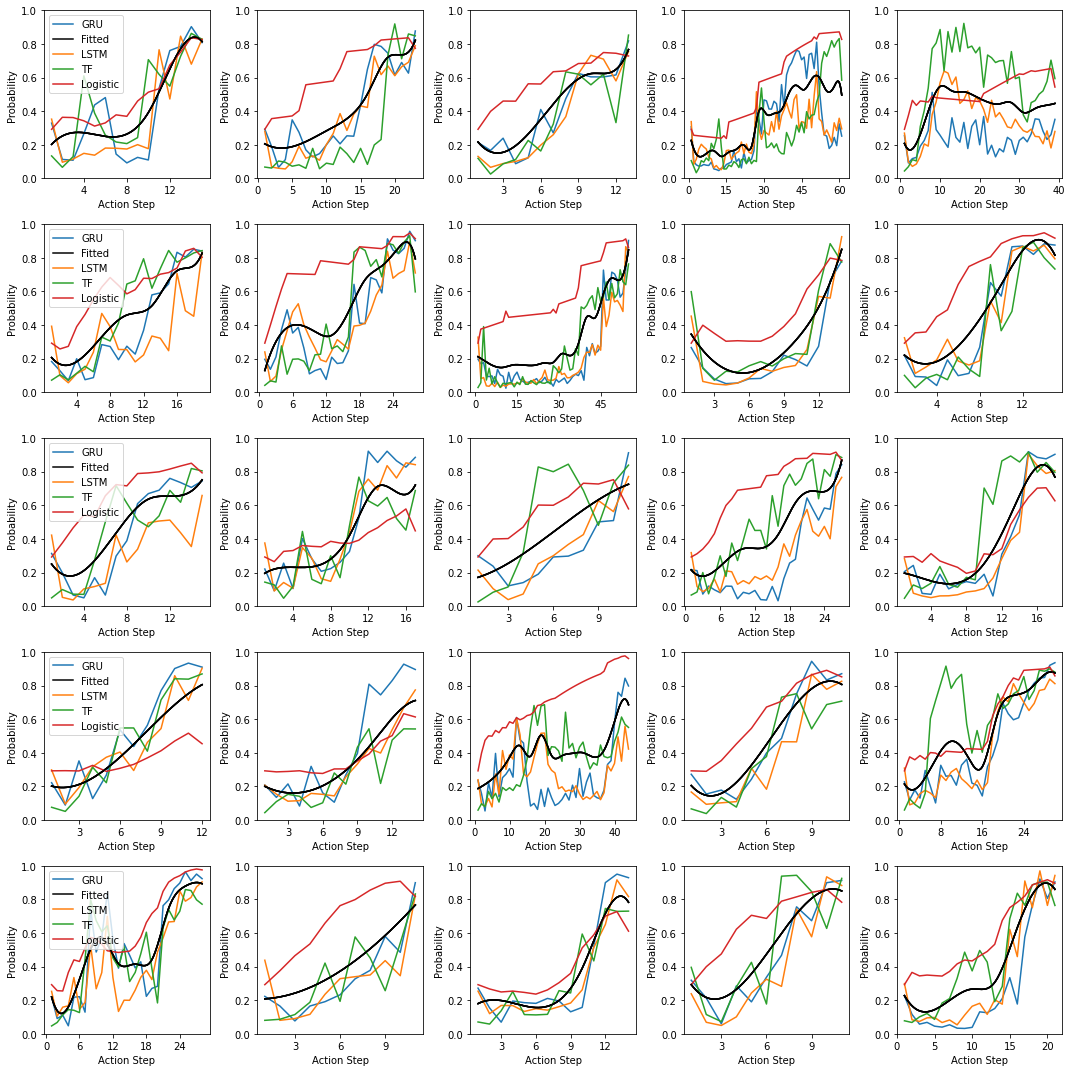

In [21]:
# 定义绘制函数的辅助函数  
def plot_cluster_curves(cluster_id, cluster_indices, curve_dicts):  
    model_names = ['GRU', 'LSTM', 'TF', 'Logistic']
    valid_indices = cluster_indices[:25] 
    fig, axs = plt.subplots(5, 5, figsize=(15, 15))
    for i, idx in enumerate(valid_indices):  
        row, col = divmod(i, 5)  
        ax = axs[row, col]  
        fitted_label_added = False  # 设置标志，用于控制是否已添加“Fitted”标签          
        # 绘制原始曲线和拟合曲线  
        for model_idx, curve_dict in enumerate(curve_dicts):  
            ax.plot(np.arange(1, len(curve_dict[idx]) + 1), curve_dict[idx], label=model_names[model_idx])
            x_fine = np.linspace(1, len(curve_dict[idx]), 200)  
            if not fitted_label_added:  
                ax.plot(x_fine, all_spline[idx], label='Fitted', color='black')  
                fitted_label_added = True  # 标记“Fitted”标签已添加
            else:  
                ax.plot(x_fine, all_spline[idx], color='black')          
        # 设置标签和标题  
        ax.set_ylim(0, 1)  
        ax.set_xlabel('Action Step')  
        ax.set_ylabel('Probability')  
        # ax.set_title(f'Cluster {cluster_id}, ID {idx}')  
        # 设置x轴为整数
        ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=5))        
        if col == 0:  # 只在第一列显示图例  
            ax.legend()  
  
# for cluster_id, indices in cluster_groups.items():  
#     plot_cluster_curves(cluster_id, indices, [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4], optimized_coeffs)  
plot_cluster_curves(0, cluster_groups[0], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

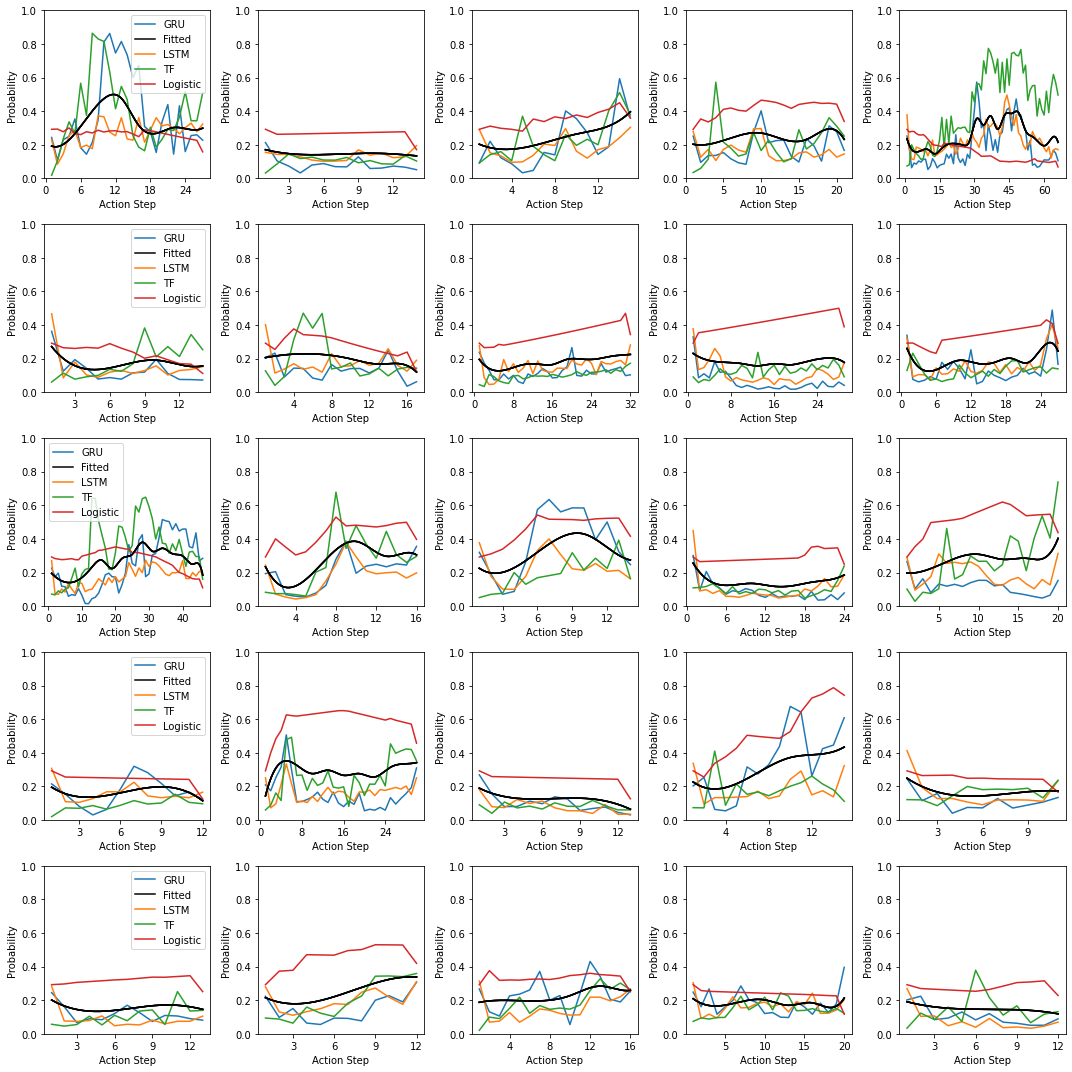

In [19]:
plot_cluster_curves(1, cluster_groups[1], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

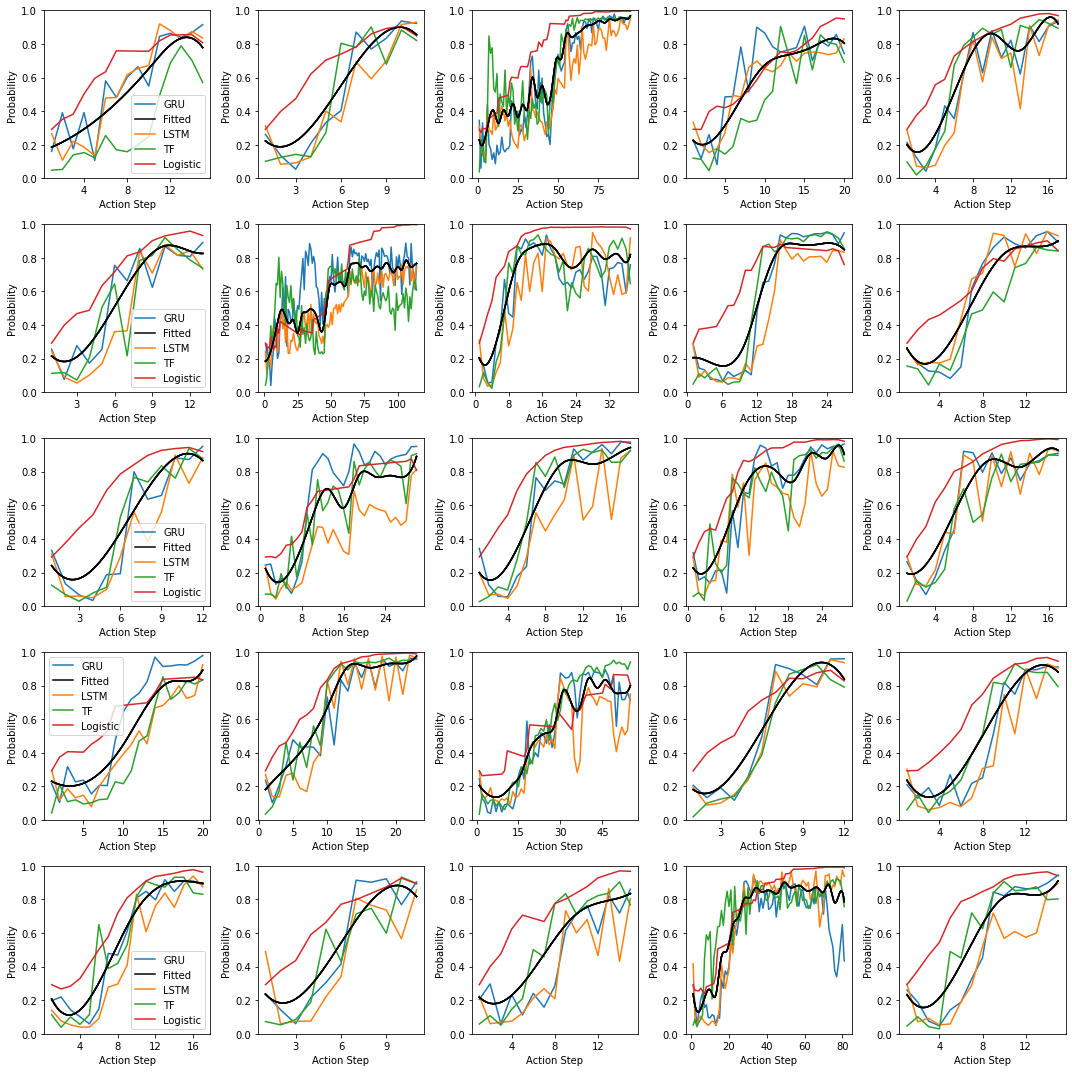

In [20]:
plot_cluster_curves(2, cluster_groups[2], [long_prob_curve_TF1, long_prob_curve_TF2, long_prob_curve_TF3, long_prob_curve_TF4])    
plt.tight_layout()  
plt.show()

用每一步动作对应曲线值的 均值±标准差 来衡量题目的动作空间

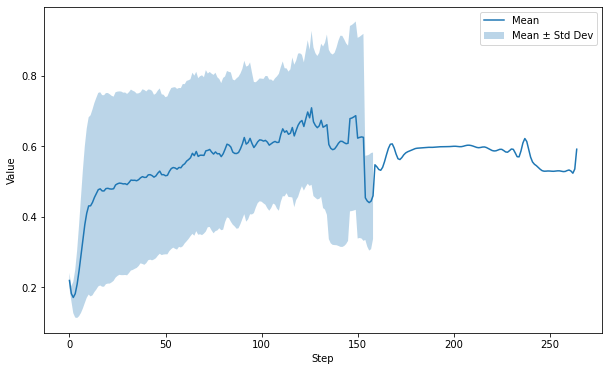

In [46]:
# 初始化均值和标准差数组  
mean_values = np.zeros(max_seq_len)  
std_values = np.zeros(max_seq_len)  
  
# 遍历每一步  
for i in range(max_seq_len):  
    # 筛选出长度至少为i+1的数组  
    valid_arrays = [arr[i] for arr in spline_curve.values() if i < len(arr)]  
      
    # 计算均值和标准差（如果valid_arrays非空）  
    if valid_arrays:  
        mean_values[i] = np.mean(valid_arrays)  
        std_values[i] = np.std(valid_arrays, ddof=1)  # 使用ddof=1得到样本标准差  
    else:  
        mean_values[i] = np.nan  
        std_values[i] = np.nan  
  
plt.figure(figsize=(10, 6))  
   
plt.plot(mean_values, label='Mean')  
  
plt.fill_between(range(max_seq_len), mean_values - std_values, mean_values + std_values,  
                 alpha=0.3, label='Mean ± Std Dev')    
plt.legend()  
plt.xlabel('Step')  
plt.ylabel('Value')  
plt.show()